<img src="https://image.ibb.co/eEk5sb/jads_logo.png" alt="jads_logo" border="0"  width=500>

<h1 align=center> Introduction to Data Science (JBP010) </h1>
<h2 align=center><i>The Quantified Self</i></h2>

<h3 align=center> December 17, 2017</h3>
<br/>
<hr>

## 1. Introduction

### 1.1 Who Owns Your Mobile Data? 

*Nowadays more personal information is collected than ever before. Yet, as an everyday consumer it can be challenging and cumbersome to gain insights in your self-generated data, let alone get a grip on all these digital records. But it oftentimes doesn't get that far: data ownership is claimed by commercial parties while your data is typically hidden right in front of your own eyes. It is not for nothing that people came up with the analogy "data is the new gold"; data literally has a high price tag and it therefore doesn't come as a surprise that the number of self-quantification tools which actually allow you to export usage data can be counted on the fingers of one hand.*

*There are a few exceptions to the rule though, in fact this notebook demonstrates that personal records generated by a device almost all millenials actively use (Figure 1), a mobile-phone, can provide far-reaching and profound insights into someone's everyday behaviour without its user even consciously realizing it.*


<img src="img/Mobile_Internet_Usage.jpg" width=750px>
<p style="clear: both"><caption><center><i> Figure 1: Mobile internet usage by device type <a href="https://www.statista.com/study/42284/mobile-device-usage-in-the-netherlands/">(Statista, 2017)</a></center></i></caption></p>


### 1.2 Contents & Structure
This introductory chapter is followed-up by the following two sections:

** Descriptive & Predictive Analyses ** <br />
Drawing from a time-series dataset (n=4.067) collected between May 2017 and October 2017, section 2.2 addresses ten descriptive questions which mainly aim to embody the potency of phone usage data and its multi-applicability in a variety of domains ranging from identifying sleep patterns to estimating a person's average daily activity. Then, section 2.3 gives another concrete application in the field of predictive analytics which reveals the predictable nature of human beings. 

** Business Case ** <br />
Given the findings in the former chapter, the intention behind the business case is to outline how personal data collection by mobile phones can create societal and economical value in the field of academic research. Note, that the business case has been included as a separate pdf-file.


## 2. Data Analysis

### 2.1 Data Collection & Feature Engineering

For the purpose of data-collection an iPhone app called [Moments](https://inthemoment.io) has been installed which stores the following attributes for every phone pick-up: 

| Feature | Definition | 
| :------- | :----------- | 
| `longitude` |  Horizontal coordinate according to the geographic coordinate system the moment the phone is picked up. |
| `latitude` |  Vertical coordinate according to the geographic coordinate system the moment the phone is picked up. |
| `location_accuracy` | An indication of the accuracy of the longitude and latitude coordinates the moment the phone is picked up. |
| `date` | The current date on the day of the phone session displayed in the following format: `DD/MM/YYYY` |
| `time` | The current time at the moment of the phone pick-up displayed in the following format: `hh/mm/ss`|
| `length_in_seconds` | The duration of the phone session (i.e. the time between unlocking and locking). | 
| `starting_batterylevel` | The battery level of the phone at the moment of phone pick-up expressed as a decimal number between 0 and 1. |
| `ending_batterylevel` | The battery level of the phone at the end of the session  expressed as a decimal number between 0 and 1. |

At first sight it might not seem as if these 8 columns contain plenty of unique insights. To a certain level that is correct: the added value is in deriving new features based on the data at hand. After the relevant libraries and data have been imported, a step-by-step explanation of how the sleeping time is derived follows. 

In [1]:
# import data manipulation, data computation and visualisation modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# show matplotlib plots in Jupyter notebooks
% matplotlib inline

In [2]:
# ------------- sessions -------------
# read session data as pandas dataframe
df = pd.read_table('Data/2017_11_27_Sessions_data_final.csv', sep=',', parse_dates=['date'])
# note that there is missing data in September
# because of privacy reasons personal data has not been published on Github

# remove empty rows
df = df.iloc[:4067]

# convert to time
df['time'] = pd.to_datetime(df.time)

# ------------- time categories -------------
# create additional columns for the hour, minute and time (as numeric fraction)
df['hour'] = df.time.dt.hour 
df['minute'] = df.time.dt.minute 
df['time_num'] = df.time.dt.hour + df.time.dt.minute/60

# convert into TimeDelta pandas series
for seconds in df.length_in_seconds:
    df.loc[df.length_in_seconds == seconds, 'length_session'] = pd.Timedelta(seconds=seconds)
    
# get weekday and convert into category
df['weekday_name'] = df.date.dt.weekday_name
df['weekday_name'] = df['weekday_name'].astype('category', categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# get month
df['month'] = df.date.dt.month

# derive weekend boolean
df['weekend'] = df['weekday_name'].isin(['Saturday', 'Sunday'])

# ------------- set color scheme -------------
flatui = ["#9b59b6", "#95a5a6", "#3498db",  "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)

#### Reverse Engineer Bed Time

These days our mobile phones are literally an extension to our everyday life. For most of us it's the first thing we touch after we wake up. And I am not any different: my mobile phone is almost always within arms reach, even when I am sleeping. That is why the bed, sleep and thus sleeping time can be reasonably\* approximated by the last and first phone session respectively. The challenge is, however, to identify the last session because the bedtime can be either before or after midnight. That is to say, simply taking the maximum session time of a day will not work. By defining a set of time constraints (e.g. bed times are after 20:30) it has been possible to automatically identify the bed-time for most of the cases. For a relatively small subset it was sometimes necessary to manually determine the bedtime or come up with a sensible value due to a violation of earlier assumptions. 


\* *This statement assumes that I don't wake up in the middle of the night, unlock my phone and continue sleeping afterwards. As will turn out later, this hypothesis is confirmed by the data.*

In [3]:
# combine date and two in one column and convert to time format
df['date_time'] = df.date.dt.date.map(str) + " " + df.time.dt.time.map(str)
df['date_time'] = pd.to_datetime(df.date_time)

# sort date_time column and reset dataframe index
df = df.sort_values(['date','time'])
df.reset_index(inplace=True)

# calculate the difference in seconds between follow-up sessions
for counter in range(len(df)-1):
    df.loc[counter, 'difference'] = (df.loc[counter+1,'time'] - df.loc[counter,'time']).seconds

**Bed-time**

In [4]:
# create filter for bed-time between 20:30 and 05:30 and at least 5 hours of consecutive sleep
bed_time_filter = ((df.time < "05:30") | (df.time > "20:30")) & (df.difference > 18000)

# create new dataframe for bed_times
bed_times = df.loc[bed_time_filter, ['date','difference', 'time','length_in_seconds']].sort_values('date')

In [5]:
# convert into TimeDelta pandas series
for seconds in bed_times.length_in_seconds:
    bed_times.loc[bed_times.length_in_seconds == seconds, 'length_session'] = pd.Timedelta(seconds=seconds)

# derive end_session (i.e. the time I put away my phone)
bed_times['end_session'] = bed_times.time + bed_times.length_session

In [6]:
# identify dates with two bed-times (i.e. bed_time after 12AM and before 12AM on the same day)
count_dates = df.loc[bed_time_filter, ['date','difference', 'time','end_session']].groupby('date').count()['difference']
date_double = count_dates[count_dates > 1].index

# for dates with two bed-times fix the date
bed_times.loc[(bed_times.time >= "00:00") & ~(df.date.isin(date_double)), ["date"]] = bed_times.loc[(bed_times.time >= "00:00") & ~(df.date.isin(date_double)), "date"] - pd.DateOffset(1)
time_double = bed_times.loc[(df.date.isin(date_double))].groupby('date').time.min()
bed_times.loc[(df.date.isin(date_double)) & df.time.isin(time_double), 'date'] = bed_times.loc[(df.date.isin(date_double)) & df.time.isin(time_double), 'date'] - pd.DateOffset(1) 

In [7]:
# create bed time only column (without date)
bed_times['time_bed_time'] = bed_times.end_session.dt.time

In [8]:
# save bed_times as csv-file
bed_times.to_csv('bed_times.csv', columns=['date', 'time_bed_time'], index=False)

**Wake-up time**

In [9]:
# determine moment of wake-up (i.e. session after bed_time session)
wake_up_times = df.loc[bed_times.index+1, ['date', 'time']]

In [10]:
# calculate sleep duration (from previous day to given date)
# calculate what time the phone was put off (rather than the session started)
for counter in bed_times.index:
    wake_up_times.loc[counter+1, 'sleep'] = df.loc[counter+1,'date_time'] - (df.loc[counter,'date_time'] + df.loc[counter,'length_session'])
    
wake_up_times['sleep'] = wake_up_times.sleep.dt.seconds

In [11]:
wake_up_times.head()

,date,time,sleep
35,2017-05-09,2017-12-17 09:44:10,155
56,2017-05-10,2017-12-17 09:14:30,27468
75,2017-05-11,2017-12-17 08:59:47,30507
101,2017-05-12,2017-12-17 08:23:42,29540
124,2017-05-13,2017-12-17 08:39:40,22836


In [12]:
# check for incorrect sleeping_times (due to falling asleep with phone)
wake_up_times.loc[wake_up_times.sleep < (60*60*5)]

,date,time,sleep
35,2017-05-09,2017-12-17 09:44:10,155
369,2017-05-22,2017-12-17 08:21:54,8428
650,2017-06-04,2017-12-17 08:34:29,12150
1368,2017-07-01,2017-12-17 08:37:02,15739
2565,2017-08-12,2017-12-17 07:52:22,15603
2854,2017-08-23,2017-12-17 08:32:45,9809
2864,2017-08-24,2017-12-17 08:49:43,13830


In [13]:
# note that the session length of the previous bed_time session confirms that for all records
bed_times.loc[bed_times.length_session > '01:45:00', ['date', 'time', 'length_session', 'time_bed_time']]

,date,time,length_session,time_bed_time
34,2017-05-08,2017-12-17 01:10:50,08:30:45,09:41:35
368,2017-05-21,2017-12-17 00:15:37,05:45:49,06:01:26
479,2017-05-26,2017-12-17 00:24:32,03:24:38,03:49:10
649,2017-06-03,2017-12-17 00:27:52,04:44:07,05:11:59
1367,2017-06-30,2017-12-17 00:12:34,04:02:09,04:14:43
2564,2017-08-11,2017-12-17 01:33:31,01:58:48,03:32:19
2853,2017-08-22,2017-12-17 02:13:38,03:35:38,05:49:16
2863,2017-08-23,2017-12-17 00:41:50,04:17:23,04:59:13
3291,2017-09-29,2017-12-17 00:03:29,02:10:21,02:13:50


In [14]:
# replace with median sleep-time
wake_up_times.loc[wake_up_times.sleep < (60*60*5), 'sleep'] = wake_up_times.sleep.median()

In [15]:
# do the same for unrealistic wake-up times
# because has not been used at wake-up
wake_up_times.sort_values('sleep').tail(10)

,date,time,sleep
1402,2017-07-02,2017-12-17 10:35:14,35567.0
1270,2017-06-27,2017-12-17 12:01:28,38434.0
875,2017-06-13,2017-12-17 11:18:19,39746.0
1236,2017-06-26,2017-12-17 09:06:38,40552.0
570,2017-05-31,2017-12-17 12:26:41,41497.0
440,2017-05-25,2017-12-17 13:35:23,44246.0
2479,2017-08-09,2017-12-17 14:47:51,44398.0
2471,2017-08-08,2017-12-17 16:00:35,48002.0
547,2017-05-30,2017-12-17 14:35:31,49086.0
2788,2017-08-21,2017-12-17 18:58:38,59024.0


In [16]:
# replace with median sleep-time
wake_up_times.loc[wake_up_times.sleep > (42000), 'sleep'] = wake_up_times.sleep.median()

In [17]:
# convert into time format
wake_up_times['time_wake_up'] = wake_up_times['time'].dt.time
wake_up_times['date'] = pd.to_datetime(wake_up_times['date']).dt.date

# save bed_times as csv-file
wake_up_times.to_csv('wake_up_times.csv', columns=['date', 'sleep', 'time_wake_up'], index=False)

**Add bed and wake-up times to dataframe**

In [18]:
# import wake up and bedtimes and merge with main dataframe
df_wake_up = pd.read_csv("wake_up_times.csv")
df['date'] = df.date.dt.date.map(str)
df = pd.merge(left=df, right=df_wake_up, left_on="date", right_on="date")

df_bed_time = pd.read_csv("bed_times.csv")
df = pd.merge(left=df, right=df_bed_time, left_on="date", right_on="date")

In [19]:
# check number of missing values for each column
for column in df.columns:
    print(column, sum(df[column].isnull()))

index 0
ending_batterylevel 0
location_accuracy 0
longitude 0
latitude 0
length_in_seconds 0
starting_batterylevel 0
date 0
time 0
hour 0
minute 0
time_num 0
length_session 0
weekday_name 0
month 0
weekend 0
date_time 0
difference 0
sleep 0
time_wake_up 0
time_bed_time 0


In [20]:
# convert back into datetime format
df['time'] = pd.to_datetime(df.time)
df['date'] = pd.to_datetime(df.date)

### 2.2  Descriptive Analysis

### 2.2.1 How many hours of sleep do I get on a typical night? 


With 95% certainty I sleep between 7.05 and 7.47 hours each night. There is not any significant difference in the total hours of sleep during working days and the weekend, but during the summer vacation (July/August) I slept significantly shorter than in other months (t=3.19, p < 0.0001). 

In [21]:
# convert seconds into hours
df['sleep'] = df.sleep / 3600

/Users/RoyKlaasseBos/RoyKlaasseBos/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


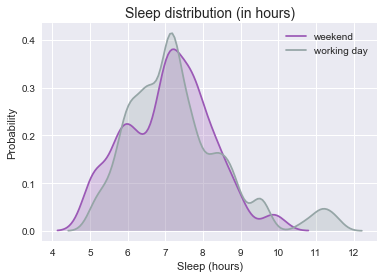

In [22]:
# plot sleep distribution for working days and the weekend
sns.kdeplot(df.loc[df.weekend, 'sleep'], shade=True, shade_lowest=False, label='weekend')
sns.kdeplot(df.loc[~df.weekend, 'sleep'], shade=True, shade_lowest=False, label='working day')
plt.title("Sleep distribution (in hours)", size=14)
plt.ylabel("Probability")
plt.xlabel("Sleep (hours)")
plt.show()

In [23]:
# convert time format into (continuous) numerical format
df['time_wake_up'] = pd.to_datetime(df.time_wake_up)
df['time_bed_time'] = pd.to_datetime(df.time_bed_time)

df.loc[df.time_bed_time.dt.hour <= 6, 'time_bed_time_num'] = (df.time_bed_time.dt.hour + 24) + df.time_bed_time.dt.minute / 60
df.loc[df.time_bed_time.dt.hour >6, 'time_bed_time_num'] = (df.time_bed_time.dt.hour) + df.time_bed_time.dt.minute / 60
df['time_wake_up_num'] = df.time_wake_up.dt.hour + df.time_wake_up.dt.minute / 60

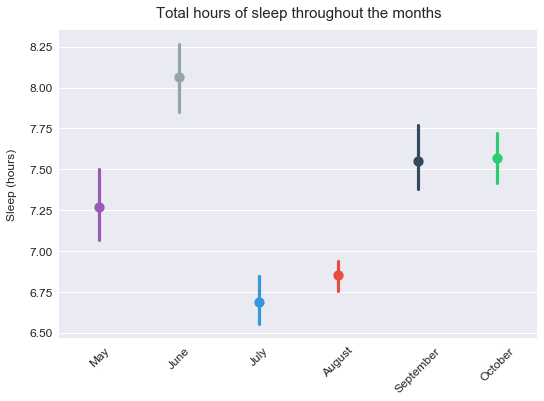

In [24]:
# create factorplot (with 95% CI) to compare differences by month
fig = plt.figure(figsize=(12,8))
sns.factorplot(x='month', y='sleep', hue='month', data=df, legend=False, ci=100, aspect=1.5, size=5)
plt.title("Total hours of sleep throughout the months", size=15, y=1.02)
plt.xlabel("")
plt.ylabel("Sleep (hours)", size=12, labelpad=12)
plt.xticks(range(6), ['May', 'June', 'July', 'August', 'September', 'October'], rotation=45, size=12)
plt.yticks(size=12)
plt.show()

/Users/RoyKlaasseBos/RoyKlaasseBos/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


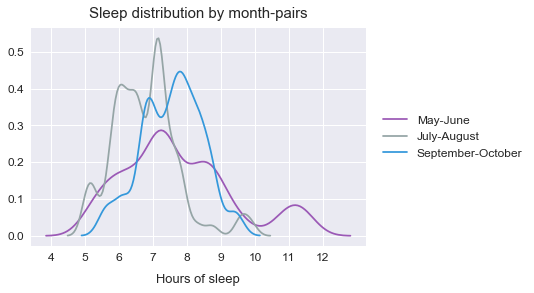

In [25]:
# create paired kernel density plot to make differences even clearer
months = {5: "May-June", 7: "July-August", 9: "September-October"}

for month in [5, 7, 9]:
    sns.distplot(df.loc[(df.month==month) | (df.month==month+1) , 'sleep'], hist=False, label=months[month])
plt.title("Sleep distribution by month-pairs", size=15, y=1.02)
plt.legend(bbox_to_anchor=(1.02, 0.65), loc='upper left', fontsize=12)
plt.xticks(range(4,13), size=12)
plt.xlabel("Hours of sleep", labelpad=11, size=13)
plt.yticks(size=12)
plt.show()

---

### 2.2.2 Is there a relationship between wake up time and total hours of sleep? 

There is a strong positive correlation between the wake-up time and the hours of sleep (Pearsons r = 0.54, p < 0.0001). This implies that  I typically do *not* go to bed early the night before days I have to wake up early (e.g. because of school).

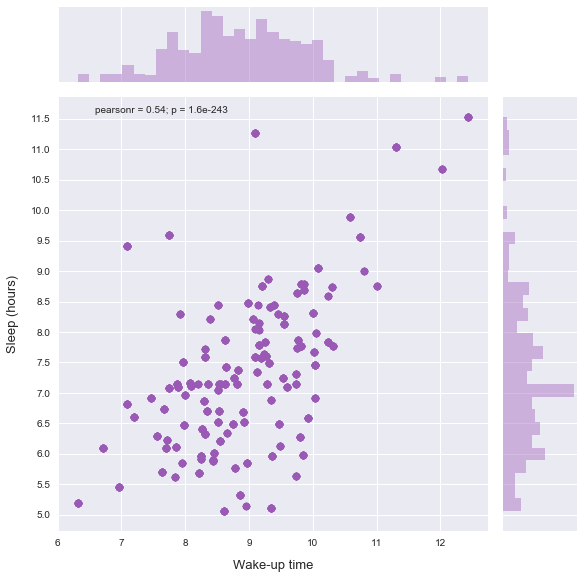

In [26]:
# exclude outliers and then plot datapoints 
k1 = sns.jointplot('time_wake_up_num', 'sleep', df[(df.time_wake_up_num > 5) & (df.time_wake_up_num < 13)], kind='scatter', size=8)
k1.ax_joint.set_xlabel("Wake-up time", labelpad=12, size=13)
k1.ax_joint.set_ylabel("Sleep (hours)", labelpad=12, size=13)
k1.ax_joint.set_yticks(np.arange(5,12,0.5))
plt.show()

---

### 2.2.3 When am I most active on my phone?

Between 12AM and 1AM, just before bed-time, I spend 24 minutes on my phone on average. Also, during waking up (8AM-10AM) I tend to use my phone more actively. Throughout the day I use my phone about 4 minutes every hour. 

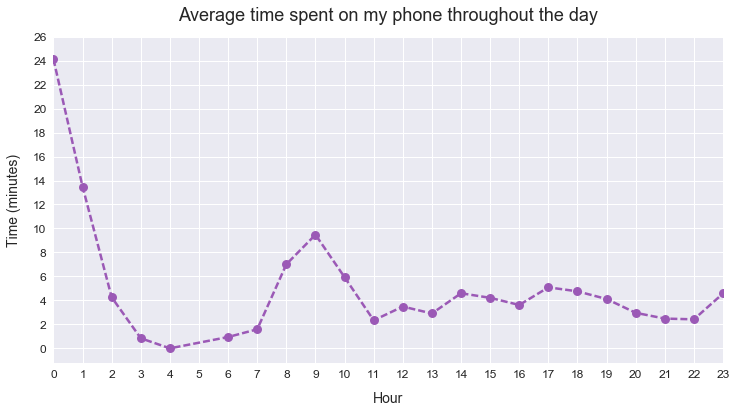

In [27]:
# increase figure size
fig = plt.figure(figsize=(12,6))

# convert total time to minutes per day
(df.groupby('hour').length_in_seconds.sum() / len(df.date.unique()) / 60).plot(marker='o', linestyle="--", linewidth=2.5, markersize=9)
plt.title("Average time spent on my phone throughout the day", size=18, y=1.03)
plt.xticks(range(24), size=12)
plt.xlabel("Hour",fontsize=14, labelpad=12)
plt.yticks(list(range(0,27,2)), size=12)
plt.ylabel("Time (minutes)", size=12, labelpad=12, fontsize=14)
plt.show()

In conjunction with the previous plot it follows that I use my phone most frequently - but for relatively short bursts of time (+/- 2.5 minutes) - between 12AM and 17AM. The session length, on the other hand, is much longer around midnight: 24/1.5 = 16 minutes on average.

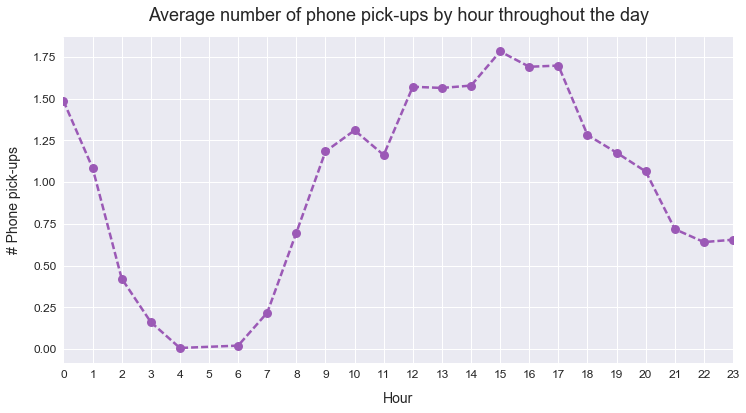

In [28]:
fig = plt.figure(figsize=(12,6))
(df.groupby('hour').date_time.count()/142).plot(marker='o', linestyle="--", linewidth=2.5, markersize=9)
plt.title("Average number of phone pick-ups by hour throughout the day", size=18, y=1.03)
plt.xlabel("Hour",fontsize=14, labelpad=12)
plt.ylabel("# Phone pick-ups", size=12, labelpad=12, fontsize=14)
plt.xticks(range(24), size=12)
plt.yticks(size=12)
plt.show()

---

### 2.2.4 How much do I move on a given day?

My own day-to-day movements are reasonably well represented by my phone because I have my phone almost always with me (except during sports) and I also tend to use my phone regularly. Given the longitude and latitude coordinates (i.e. my location at a certain moment) the straight line distance between two locations can be determined with the following formula:  

In [29]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371* c
    
    return km

In [30]:
# sort date_time column and reset dataframe index
df = df.sort_values(['date','hour', 'minute'])
df.reset_index(inplace=True)

# calculate distance (in km) between two follow-up sessions
for counter in range(1, len(df)):
    df.loc[counter, 'distance'] = haversine(df.loc[counter-1, 'longitude'], df.loc[counter-1, 'latitude'], df.loc[counter, 'longitude'], df.loc[counter, 'latitude'])

The two outliers on the 9th and 22th of July can be attributed to my outward (XXX, Porto) and return flight (Porto, XXX) during the summer vacation. 

In [31]:
# detect distance outliers
df[['date', 'distance']].sort_values(by='distance', ascending=False).head()

,date,distance
1441,2017-07-22,1568.405389
1121,2017-07-09,1525.539423
940,2017-06-30,130.559139
402,2017-06-03,130.551739
2454,2017-09-25,130.549028


After these outliers have been excluded, it follows that with 95% certainty I travel between 26.7 and 42.3 kilometer each day. 

In [32]:
distance_by_day = df[(df.distance > 0) & (df.distance < 1000)].groupby('date').distance.sum()
print("Lower bound (95% CI):", round(distance_by_day.mean() - 1.96* distance_by_day.std() / (len(df.date.unique()))**0.5, 1), "km")
print("Upper bound (95% CI):", round(distance_by_day.mean() + 1.96* distance_by_day.std() / (len(df.date.unique()))**0.5, 1), "km")

Lower bound (95% CI): 26.3 km
Upper bound (95% CI): 42.8 km


This calculation assumes, however, that the data is normally distributed which turns out to be not the case (Figure below). The bi-modal distribution can be explained by my travelling habits: twice a week I travel between my student room in XXX and my parent's home (about 130 km apart). This will also become clear from the geographical charts in the next section.

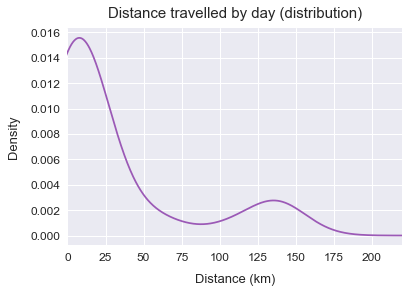

In [33]:
df.loc[df.distance < 1000].groupby('date').distance.sum().plot(kind='kde')
plt.xlim(0,220)
plt.title("Distance travelled by day (distribution)", y=1.02, size=15)
plt.xlabel("Distance (km)", labelpad=11, size=13)
plt.ylabel("Density", size=13, labelpad=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

The data includes both vacation (July/August) and school days (September/October). To find out whether there are any differences in daily travel habits throughout these two periods we will have a look at the dataframes: `avg_km_vacation` and `avg_km_school`.

In [34]:
# determine frequency of weekdays in vacation (on some days there weren't any records)
# JADS introduction week began Monday on the 28th of August 2017
vacation_dates = df[(df.date >= '2017-07-01') & (df.date < '2017-08-27')].groupby(['weekday_name', 'date'])['weekday_name', 'date'].count()
vacation_dates = [vacation_dates.index[counter][0] for counter in range(len(vacation_dates.index))]

freq_vacation_dates = {day: vacation_dates.count(day) for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}
freq_vacation_dates

{'Friday': 5,
 'Monday': 8,
 'Saturday': 5,
 'Sunday': 7,
 'Thursday': 6,
 'Tuesday': 8,
 'Wednesday': 8}

In [35]:
# convert the total distance to average distance by week day (during the vacation)
avg_km_vacation = df.loc[(df.distance < 500) & (df.date < '2017-08-27') & (df.date >= '2017-07-01')].groupby('weekday_name').distance.sum() / [5, 8, 5, 7, 6, 8, 8]
avg_km_vacation = avg_km_vacation.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
avg_km_vacation

weekday_name
Monday       14.299802
Tuesday      25.138450
Wednesday    27.637576
Thursday     10.853283
Friday        9.696312
Saturday     10.885964
Sunday       17.304660
Name: distance, dtype: float64

In [36]:
# repeat the same for the school period
school_dates = df[(df.date >= '2017-09-01')].groupby(['weekday_name', 'date'])['weekday_name', 'date'].count()
school_dates = [school_dates.index[counter][0] for counter in range(len(school_dates.index))]

freq_school_dates = {day: school_dates.count(day) for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}
freq_school_dates

{'Friday': 5,
 'Monday': 6,
 'Saturday': 5,
 'Sunday': 5,
 'Thursday': 5,
 'Tuesday': 5,
 'Wednesday': 5}

In [37]:
# convert the total distance to average distance by week day (during school)
avg_km_school = df.loc[(df.distance < 500) & (df.date >= '2017-09-01')].groupby('weekday_name').distance.sum() / ([5, 6, 5, 5, 5, 5, 5])
avg_km_school = avg_km_school.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
avg_km_school

weekday_name
Monday        26.702588
Tuesday      103.370699
Wednesday     35.798222
Thursday      51.575828
Friday        70.538915
Saturday      20.499632
Sunday         5.655477
Name: distance, dtype: float64

The bar chart below pinpoints the dissimilarity in total daily movements during the summer vacation (95% CI: 9.3 - 25.8 km) and school time (95% CI: 27.4 - 61.3 km). Since I don't have to travel to the university neither my student room during the vacation the total distance is significantly lower. Aside from that, the average daily distance on Tuesday is relatively high which can be explained by the commute from my parent's home. In the same way I usually travel back either on Thursday or Friday.

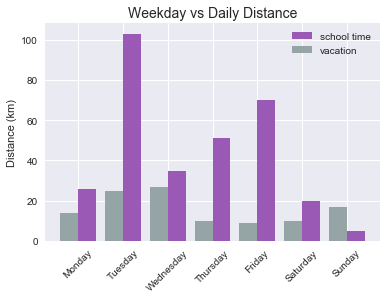

In [38]:
# create bar chart to compare categories side-by-side
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ypos = np.arange(len(list(avg_km_school.astype(int))))
plt.bar(ypos+0.2, list(avg_km_school.astype(int)), width=0.4, label='school time')
plt.bar(ypos-0.2, list(avg_km_vacation.astype(int)), width=0.4, label='vacation')
plt.xticks(ypos, weekdays, rotation=45)
plt.ylabel("Distance (km)")
plt.legend()
plt.title("Weekday vs Daily Distance", size=14)
plt.show()

---

### 2.2.5 Where do I spend most time on my phone? 

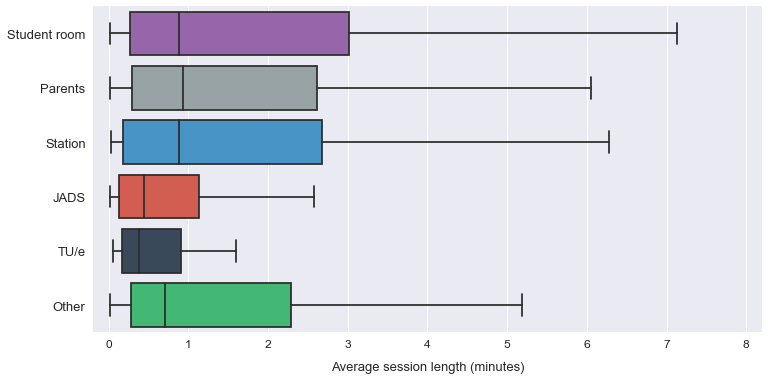

In [43]:
# plot average length session
fig = plt.figure(figsize=(12,6))
order_locations = ["Student room", "Parents", "Station", "JADS", "TU/e", "Other"]
sns.boxplot(df[df.length_in_seconds < 500].length_in_seconds/60, df.location, order=order_locations, fliersize=0)
plt.ylabel("")
plt.yticks(range(6), order_locations, size=13)
plt.xticks(range(9), size=12)
plt.xlabel("Average session length (minutes)", labelpad=11, size=13)
plt.xlim((-0.2,8.2))
plt.show()

---

### 2.2.6 How often and for how long did I go to JADS? 

Due to missing data in the month September only October will be taken into account for this question. This comes down to 6 (out of 22) unique working days in October. By subtracting the arrival time from the departure time an estimation can be made of the total time spent at the monastery in XXX: about 14 hours in October. 

In [44]:
# How often did I go to JADS in October (the 10th month)?
jads = df[(df.location=="JADS") & (df.month == 10)].groupby('date').location.count().index
print("Number of times at JADS in October:", len(jads))
print(jads)

Number of times at JADS in October: 6
DatetimeIndex(['2017-10-05', '2017-10-10', '2017-10-11', '2017-10-13',
               '2017-10-19', '2017-10-20'],
              dtype='datetime64[ns]', name='date', freq=None)


In [45]:
# how long did I spend at JADS in October? 
total_jads = (df.loc[(df.date.isin(jads)) & (df.location=="JADS")].groupby('date').time.max()-df.loc[(df.date.isin(jads)) & (df.location=="JADS")].groupby('date').time.min())
print("TIME BY:", total_jads)
print("TOTAL TIME:", total_jads.sum())

TIME BY: date
2017-10-05   01:34:31
2017-10-10   03:40:06
2017-10-11   02:00:27
2017-10-13   01:30:12
2017-10-19   00:52:02
2017-10-20   04:22:01
Name: time, dtype: timedelta64[ns]
TOTAL TIME: 0 days 13:59:19


---

### 2.2.7 How often did I fall asleep with my phone turned on?

This silly behaviour can be recognized by a very long session length around bed time. We first select records of which the session length is longer than 10.800 seconds and the session's start time was between 10PM and 5AM. Then, we check for the next session to make sure that I didn't use my phone another time during the night. 

A clear example of this is on the 9th of May where a session lasted for more than 8.5 hours (01:10 - 09:41) which was followed by the next session almost immediately after that at 09:44. Although there is not as much prove as for the first case, 6 other events show similar characteristics of falling asleep with the phone turned on. The challenge is, however, in distinguishing everyday behaviour (e.g. watching a series episode on my phone late at night) from the behaviour we are specifically looking for. Hence, the cut-off value has been set at 10.800 seconds since even long movies typically have a play length less than 3 hours.

In [46]:
# identify events which show signals of falling asleep with the phone turned on
fall_asleep = df.loc[(df.length_in_seconds > 9000) & ((df.hour < 5) | (df.hour > 22)), ['date', 'time', 'length_in_seconds']]
fall_asleep

,date,time,length_in_seconds
2,2017-05-09,2017-12-17 01:10:50,30645.0
219,2017-05-22,2017-12-17 00:15:37,20749.0
289,2017-05-27,2017-12-17 00:24:32,12278.0
414,2017-06-04,2017-12-17 00:27:52,17047.0
972,2017-07-01,2017-12-17 00:12:34,14529.0
2267,2017-08-23,2017-12-17 02:13:38,12938.0
2277,2017-08-24,2017-12-17 00:41:50,15443.0


In [47]:
# check whether the next moment is "the morning after" (for 8/8 records that is the case)
df.loc[fall_asleep.index + 1,['date','time']]

,date,time
3,2017-05-09,2017-12-17 09:44:10
220,2017-05-22,2017-12-17 08:21:54
290,2017-05-27,2017-12-17 08:57:17
415,2017-06-04,2017-12-17 08:34:29
973,2017-07-01,2017-12-17 08:37:02
2268,2017-08-23,2017-12-17 08:32:45
2278,2017-08-24,2017-12-17 08:49:43


---

### 2.2.8 What time do I charge my phone normally?

The plot on the left shows that I use about 30-50% of my phone its battery on a daily basis depending on my bed-time. That is because the battery consumption tends to be high (10%) after midnight (see the right plot). This is in line with the earlier finding: there is high phone activity between 12AM and 2AM (see section 2.2.3). 

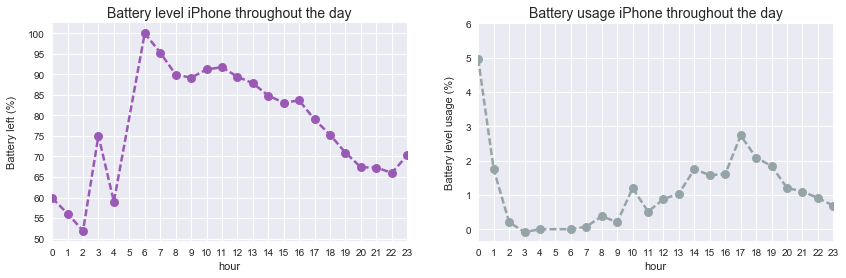

In [48]:
# create two subplots
f, axes = plt.subplots(1,2, figsize=(14,4), sharex=True) 

# battery level iPhone throughout the day
k1 = (100*df.groupby('hour').ending_batterylevel.mean()).plot(marker='o', linestyle="--", linewidth=2.5, markersize=9, ax=axes[0])
k1.set_xticks(range(24))
k1.set_ylabel("Battery left (%)", labelpad=11)
k1.set_yticks(range(50, 101, 5))
k1.set_title("Battery level iPhone throughout the day",size=14)

# battery usage iPhone throughout the day
df['difference_batterylevel'] = 100*(df['ending_batterylevel'] - df['starting_batterylevel'])
k2 = (df.groupby('hour').difference_batterylevel.sum() / -len(df.date.unique())).plot(marker='o', linestyle="--", linewidth=2.5, markersize=9, ax=axes[1], color="#95a5a6")
k2.set_ylabel("Battery level usage (%)", labelpad=11)
k2.set_yticks(range(0,7))
k2.set_title("Battery usage iPhone throughout the day",size=14)

plt.show()

The chart below may initially be a bit misleading because it doesn't depict a netto battery level increase during normal sleeping hours (between 3AM and 7AM). That is because the difference in battery level can only be calculated while the phone is actually being used. The main take-away of the chart, however, is that I tend to charge my phone (while using it) around bed-time (11PM - 2AM) and wake-up time (8AM-9AM).  

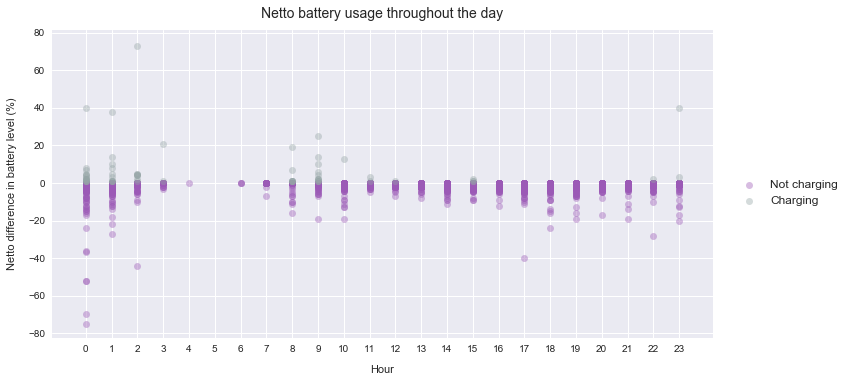

In [49]:
# create column to indicate whether the phone is being charged
df.loc[df.ending_batterylevel > df.starting_batterylevel, 'charging'] = True
df.loc[df.ending_batterylevel <= df.starting_batterylevel, 'charging'] = False

# plot netto difference by hour
sns.lmplot('hour', 'difference_batterylevel', data=df, hue="charging", aspect=2, fit_reg=False, legend_out=False, scatter_kws= {"alpha":0.4})
plt.legend(["Not charging", "Charging"], bbox_to_anchor=(1.02, 0.55), loc='upper left', fontsize=12)
plt.xticks(range(24))
plt.title("Netto battery usage throughout the day", size=14, y=1.02)
plt.ylabel("Netto difference in battery level (%)", labelpad=11)
plt.xlabel("Hour", labelpad=11)
plt.show()

Now by calculating the charging/not charging ratio by hour (#gray dots / #purple dots), we can derive that I am most likely to charge my phone (while using it) between 10PM and 3AM. Also, it shows that I never charged my phone while using it in the following two time-slots: 13:00-14:59 and 16:00-21:59.

In [50]:
charging_ratio = df.loc[(df.charging)].groupby('hour').difference_batterylevel.count() /  df.loc[(df.charging == False)].groupby('hour').difference_batterylevel.count() 
charging_ratio[charging_ratio.notnull()].sort_values(ascending=False)

hour
2     0.153846
3     0.095238
0     0.076531
8     0.076087
9     0.070064
1     0.069444
23    0.021978
11    0.012270
15    0.012000
22    0.011111
10    0.005405
12    0.004505
Name: difference_batterylevel, dtype: float64

---

### 2.2.9 Does my sleeping length depend on the location?

Due to the vacation days I slept most of the time at my parent's home (56%), followed by my student room (36%) and a category "Other" which includes all other sleeping locations (8%). It turns out in the latter location I have slept remarkably shorter.

In [51]:
sleeping_location = df.loc[(df.hour > 21) | (df.hour<5)].groupby('location').date.unique()
sleeping_location_freq = {sleeping_location.index[counter]: len(sleeping_location[counter]) for counter in range(len(sleeping_location))}
sleeping_location_freq

{'Other': 10, 'Parents': 72, 'Student room': 46}

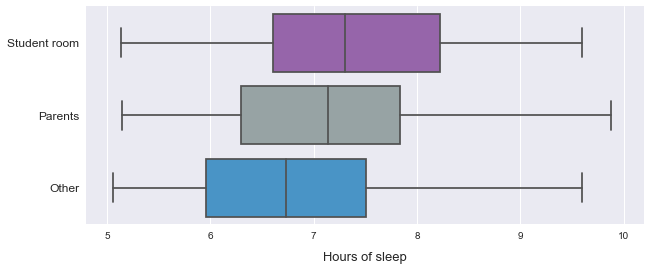

In [52]:
# plot hours of sleep vs location
fig = plt.figure(figsize=(10,4))
order_locations = ["Student room", "Parents", "Other"]
sns.boxplot(df[df.location.isin(order_locations)].sleep, df.location, order=order_locations, fliersize=0)
plt.ylabel("")
plt.xlabel("Hours of sleep", labelpad=11, size=13)
plt.xlim(4.8,10.2)
plt.yticks(size=12)
plt.show()

The two boxplots below clearly indicate that all the events labeled as "Other" are located between longitude coordinates -8.60 to -8.30 and latitude coordinates 41.15 to 41.45. That is in Portugal: my holiday destination!

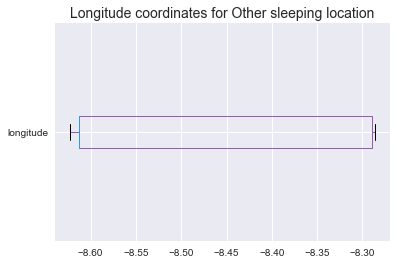

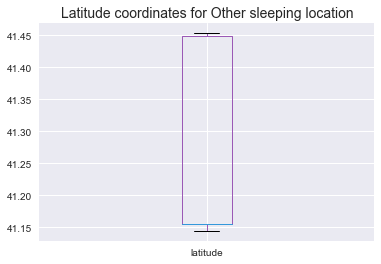

In [53]:
# find coordinates for other sleeping location
filter_time_loc = (df.location=='Other') & ((df.hour > 21) | (df.hour<5))

k1 = df.loc[filter_time_loc, ['longitude']].plot(kind='box', vert=False)
k1.set_title("Longitude coordinates for Other sleeping location", size=14)
k2 = df.loc[filter_time_loc, ['latitude']].plot(kind='box')
k2.set_title("Latitude coordinates for Other sleeping location", size=14)
plt.show()

In [54]:
# calculate hours of sleep during holiday trip
little_sleep_dates = df.loc[(df.location=='Other') & ((df.hour > 21) | (df.hour<5))].date.unique()
little_sleep_dates

array(['2017-07-09T00:00:00.000000000', '2017-07-10T00:00:00.000000000',
       '2017-07-11T00:00:00.000000000', '2017-07-12T00:00:00.000000000',
       '2017-07-16T00:00:00.000000000', '2017-07-17T00:00:00.000000000',
       '2017-07-18T00:00:00.000000000', '2017-07-19T00:00:00.000000000',
       '2017-07-20T00:00:00.000000000', '2017-07-21T00:00:00.000000000'], dtype='datetime64[ns]')

The shorter sleeping length at the Other location can be ascribed to some late-night activities.. 

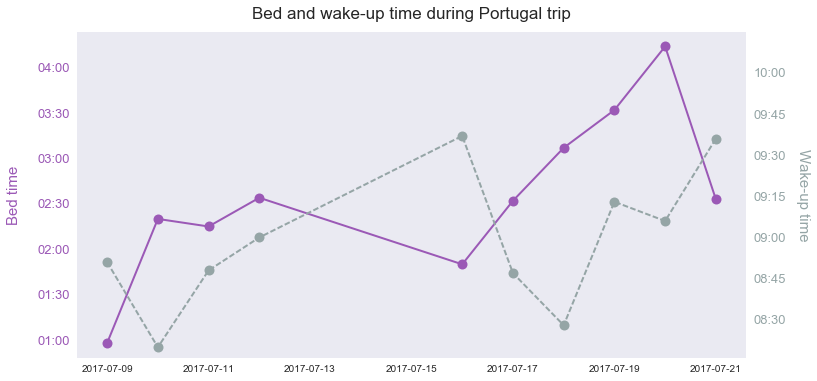

In [55]:
# create dual axis chart to compare bed and wake-up time over time

a1 = df.loc[df.date.isin(little_sleep_dates)].groupby('date')['time_bed_time_num'].median()
a2 = df.loc[df.date.isin(little_sleep_dates)].groupby('date')['time_wake_up_num'].median()

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')

ax.plot(a1, color='#9b59b6',linewidth=2, marker='o', markersize=10)
ax2.plot(a2, color='#95a5a6',linewidth=2, marker='o', linestyle='--', markersize=10)

ax.set_ylabel("Bed time",fontsize=15, labelpad=16, color="#9b59b6")
ax2.set_ylabel("Wake-up time",fontsize=15, rotation=-90, labelpad=24, color="#95a5a6")
ax2.set_ylim(ymax=10)
ax.set_yticklabels(labels=["", "01:00", "01:30", "02:00", "02:30", "03:00", "03:30", "04:00", ""], color="#9b59b6", fontsize=13)
ax2.set_yticklabels(labels=["08:15", "08:30", "08:45", "09:00", "09:15","09:30", "09:45", "10:00"], color="#95a5a6", fontsize=13)

ax.grid(False)
ax2.grid(False)

plt.title("Bed and wake-up time during Portugal trip", fontsize=17, y=1.02)
plt.show()

---

### 2.2.10 How does my daily phone usage compare to my brother?

According to his phone's data my brother, Tom, not only seems to be a more heavy phone user in terms on total daily minutes spent (on average 264 more minutes than me) but also the number of pickups is a lot higher. Still, the mean session length is more than 2X as high for him.

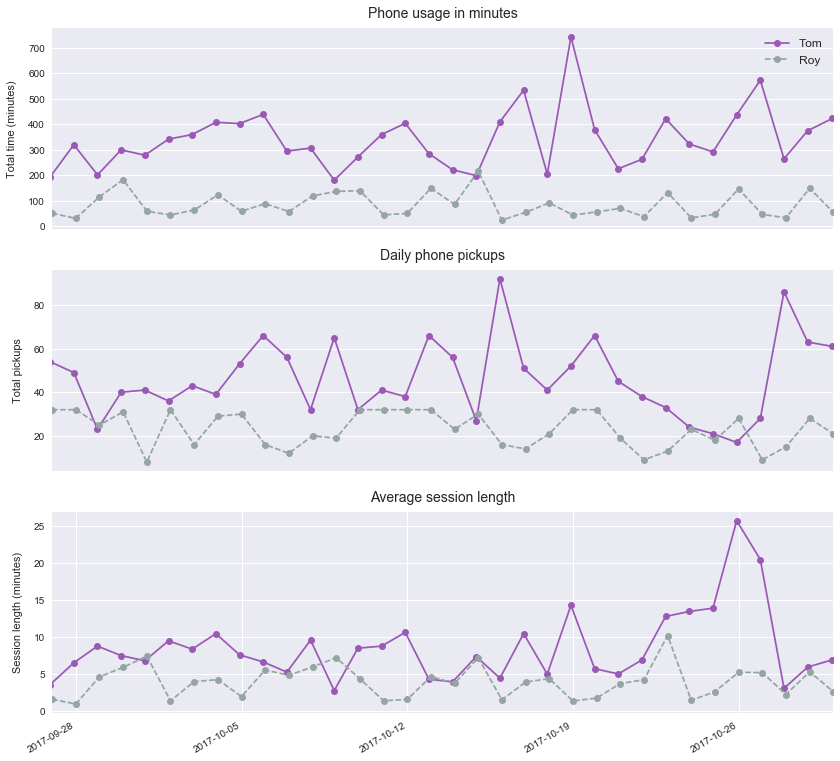

In [56]:
# import data as separate dataframe
df_tom = pd.read_csv('Data/2017_11_03_Tom_Smartphone_usage.csv')
df_tom.date = pd.to_datetime(df_tom.date)

# plot both usage diagrams in one graph
f, axes = plt.subplots(3,1, figsize=(14,14), sharex=True) 

# total time on phone
plt.subplot(311)
plt.plot(df_tom.loc[df_tom.date > '2017-09-26', 'date'], df_tom.loc[df_tom.date > '2017-09-26','minuteCount'], marker='o', label='Tom')
(df[df.date > '2017-09-26'].groupby('date').length_in_seconds.sum()/60).plot(label='Roy', marker='o', linestyle='--')
plt.legend(fontsize=12)
plt.xlabel("")
plt.xticks([])
plt.ylabel("Total time (minutes)", labelpad=11)
plt.title("Phone usage in minutes", y=1.02, size=14)

# daily phone pickups
plt.subplot(312)
plt.plot(df_tom.loc[df_tom.date > '2017-09-26', 'date'], df_tom.loc[df_tom.date > '2017-09-26','pickupCount'], marker='o', label='Tom')
(df[df.date > '2017-09-26'].groupby('date').date.count()).plot(label='Roy', marker='o', linestyle='--')
plt.legend([])
plt.xlabel("")
plt.xticks([])
plt.ylabel("Total pickups", labelpad=11)
plt.title("Daily phone pickups", y=1.02, size=14)

# 
plt.subplot(313)
plt.plot(df_tom.loc[df_tom.date > '2017-09-26', 'date'], df_tom.loc[df_tom.date > '2017-09-26','minuteCount']/df_tom.loc[df_tom.date > '2017-09-26','pickupCount'], marker='o', label='Tom')
((df[df.date > '2017-09-26'].groupby('date').length_in_seconds.sum()/60) / (df[df.date > '2017-09-26'].groupby('date').date.count())).plot(label='Roy', marker='o', linestyle='--')
plt.legend([])
plt.xlabel("")
plt.ylabel("Session length (minutes)", labelpad=11)
plt.title("Average session length", y=1.02, size=14)

plt.show()

In [57]:
# calculate average difference in daily minutes used

# create equal length arrays (i.e. the same date interval)
df_tom.set_index('date', inplace=True)
a1 = df_tom.loc[(df_tom.index > '2017-09-27') & (df_tom.index < '2017-10-31'),['minuteCount']]
a1 = a1.sort_index()
a2 = (df[df.date > '2017-09-26'].groupby('date').length_in_seconds.sum()/60)

# sum up all differences
difference_tom_roy = 0
for counter in range(len(a1)): difference_tom_roy += a1.minuteCount[counter] - a2[counter]

# display average difference
print("Additional daily phone usage by Tom: ", round(difference_tom_roy / len(a1),1), "minutes")

Additional daily phone usage by Tom:  264.6 minutes


---

---

## 2.3 Predictive Analysis

In this section we are trying to find an answer to the question: *where does Roy sleep tonight?* As we have previously seen three unique sleeping locations can be distinguished: my parents' place, my student room and a few other locations in Portugal categorized as "Other". The purpose of this analysis is to predict in which of these three places I will have a nap on a given night. Due to the summer vacation period I spent most nights at my parental house which explains the baseline accuracy of 55.2%.

| Location | Classification | Relative frequency | 
| :------------ | :--------- | :--------- | 
| Parents | 1 | 55.2% |
| Student room | 2| 37.2% |
| Other | 3| 7.6% | 

In [58]:
# create target variable categories
sleeping_filter = (df.hour > 21) | (df.hour<5)
other_sleeping = df.loc[sleeping_filter].groupby('location').date.unique()[0]
parents_sleeping = df.loc[sleeping_filter].groupby('location').date.unique()[1]
student_room_sleeping = df.loc[sleeping_filter].groupby('location').date.unique()[2]

df.loc[df.date.isin(parents_sleeping), 'sleeping_location'] = 1
df.loc[df.date.isin(student_room_sleeping), 'sleeping_location'] = 2
df.loc[df.date.isin(other_sleeping), 'sleeping_location'] = 3

In [59]:
# identify dates with missing sleeping locations: June 26th, October 19th and 30th.
df[df.sleeping_location.isnull()].date_time.dt.date.unique()

array([datetime.date(2017, 6, 26), datetime.date(2017, 10, 19),
       datetime.date(2017, 10, 30)], dtype=object)

In [60]:
# On the 26th of June the missing sleeping location can be explained by the lack of records (i.e. phone pickups) after 13:09:12
# checking my agenda shows that I spent that night in my studentroom
df[df.date == "2017-06-26"][['date','time', 'location', 'weekday_name']]
df.loc[df.date == "2017-06-26", 'sleeping_location'] = 2

In [61]:
# On the 19th of October it follows from the table below that I slept in my student room on the 19th of October
# Missing record can be explained by the time of the last pick-up that day: 20:25.
df.loc[df.date == "2017-10-19", 'sleeping_location'] = 2
df[df.date == "2017-10-19"][['date','time', 'location', 'weekday_name']]

,date,time,location,weekday_name
3043,2017-10-19,2017-12-17 07:05:55,Student room,Thursday
3044,2017-10-19,2017-12-17 09:58:27,Student room,Thursday
3045,2017-10-19,2017-12-17 10:35:39,Student room,Thursday
3046,2017-10-19,2017-12-17 10:39:41,Student room,Thursday
3047,2017-10-19,2017-12-17 10:52:57,Student room,Thursday
3048,2017-10-19,2017-12-17 11:53:58,Student room,Thursday
3049,2017-10-19,2017-12-17 11:55:26,Student room,Thursday
3050,2017-10-19,2017-12-17 12:37:17,Student room,Thursday
3051,2017-10-19,2017-12-17 13:11:12,Other,Thursday
3052,2017-10-19,2017-12-17 13:13:41,Station,Thursday


In [62]:
# repeating the same for the 30th of October gives that I slept in my parent's place
df[df.date == "2017-10-30"][['date','time', 'location', 'weekday_name']]
df.loc[df.date == "2017-10-30", 'sleeping_location'] = 1

In [63]:
# feature engineering

# boolean that indicates whether the date falls into the summer vacation
df.loc[(df.date >= "2017-07-10") & (df.date <= "2017-08-27"), "summer_vacation"] = True
df.loc[df.summer_vacation.isnull(), "summer_vacation"] = False

# boolean that indicates whether the date falls into my holiday trip to Portugal
df.loc[(df.date >= "2017-07-09") & (df.date <= "2017-07-21"), "portugal"] = True
df.loc[df.portugal.isnull(), "portugal"] = False

# boolean that indicates whether I have been at JADS that day
jads_dates = df[df.location == "JADS"].date.unique()
df.loc[(df.date.isin(jads_dates)), "JADS_visit"] = True
df.loc[df.JADS_visit.isnull(), "JADS_visit"] = False

# boolean that indicates whether I have been at XXX station that day
station = df[df.location == "Station"].date.unique()
df.loc[(df.date.isin(station)), "station_visit"] = True
df.loc[df.station_visit.isnull(), "station_visit"] = False

# total kilometers travelled that day
for date in df.date.unique():
    df.loc[df.date == date, "total_distance_day"] = df.loc[df.date == date, "distance"].sum()

# determine whether the total distance is long that day 
df.loc[df.total_distance_day > 120, 'long_commute'] = True
df.loc[df.total_distance_day <= 120, 'long_commute'] = False

# total time on phone that day
for date in df.date.unique():
    df.loc[df.date == date, "phone_total_seconds"] = df.loc[df.date == date, "length_in_seconds"].sum()

# sum of differences in battery_level 
for date in df.date.unique():
    df.loc[df.date == date, "total_difference_batterylevel"] = df.loc[df.date == date, "difference_batterylevel"].sum()

In [64]:
# assign X as a DataFrame of features (and drop correlated/irrelevant features) and y as a series of the outcome variable

# unique dates
df2 = df.loc[list(df.groupby('date').level_0.min())]

X = df2[['weekday_name', 'weekend', 'portugal', 'summer_vacation', 'JADS_visit', "long_commute", "station_visit", "total_distance_day", "phone_total_seconds", "total_difference_batterylevel"]]
y = df2.sleeping_location

In [65]:
# Function to dummy all categorical variables used for modelling
def dummy_df(df, to_dummy_list):
    for x in to_dummy_list: 
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

todummy_list = ['weekday_name', 'weekend']
X = dummy_df(X, todummy_list)

In [66]:
# Interactions
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove Interaction terms with all 0 values 
    noint_indices = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indices], axis=1)
    
    return df

In [67]:
X = add_interactions(X)

In [68]:
# use train_test_split in sklearn.cross_validation to split data into a train (80%), test (20%)
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

/Users/RoyKlaasseBos/RoyKlaasseBos/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


What follows is a selection of the two best types of Machine Learning algorithms for this classification problem. This decision has been made on the cross-validated performance metric which is expected to represent the classifier's performance well due to the  balanced classes distribution (class 1: 55.2%, class 2: 37.2%, class 3: 7.6%) 

In [69]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Dummy    0.543410
LR       0.589564
DT       0.755538
RF       0.764179
dtype: float64

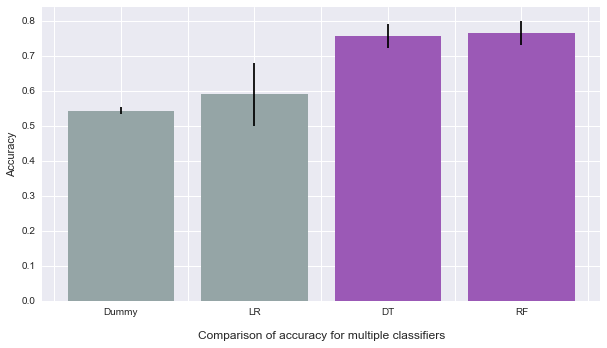

In [70]:
from collections import OrderedDict

def compare_classifiers(X, y, label, scoring="accuracy", cv=10):
    models = [
        ("Dummy", DummyClassifier(strategy="most_frequent")),
        ("LR", LogisticRegression(random_state=10)),
        ("DT", DecisionTreeClassifier(random_state=10)),
        ("RF", RandomForestClassifier(random_state=10))]

    results = OrderedDict()
    for name, model in models:
        cv_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        results[name] = cv_results

    results = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    plt.bar(range(results.shape[1]), results.mean(), yerr=results.std(), color=["#95a5a6", "#95a5a6", "#9b59b6", "#9b59b6"])
    plt.gca().set_xticklabels(["", "", "Dummy", "", "LR", "", "DT",  "", "RF", "",""])
    plt.title("Comparison of " + label + " for multiple classifiers", y=-.15)
    plt.ylabel(label.title())
    plt.subplots_adjust(bottom=.2)
    
    return results.mean()

compare_classifiers(X,y, "accuracy", cv=5)

Given these results, grid search is applied to the Decision Tree and Random Forest classifiers. The results thereof reinforce the observation in the bar chart above: the Decision Trees accuracy is rather variable. For that reason the final decision has been made for the Random Forest model which yields a cross-validated accuracy of **81.2%** on the test set (26 percentage points above the baseline model). The average confusion matrix demonstrates that while the predictions for sleeping in Portugal are perfect (100% precision), 65% of the class-2 predictions (i.e. student room) are incorrect.

In [75]:
from sklearn.grid_search import GridSearchCV

rf_params = {"n_estimators": list(range(1, 20, 3)), 
             "max_depth": list(range(4, 22, 2)), 
             "min_samples_split": list(range(4, 10, 2))}
dt_params = {"min_samples_split": list(range(4, 10, 2)), 
             "max_depth": list(range(2, 22, 2))}

def find_parameters(model, model_name, params, scoring, cv=5):
    grid = GridSearchCV(model, params, cv=cv, scoring=scoring)
    grid.fit(X_train, y_train)
    print(model_name.upper())
    print(str(scoring), ": ", grid.best_score_)
    print(grid.best_params_)

find_parameters(RandomForestClassifier(random_state=10), "Random Forest", rf_params, "accuracy")
find_parameters(DecisionTreeClassifier(random_state=10), "Decision Tree", dt_params, "accuracy")

RANDOM FOREST
accuracy :  0.8118811881188119
{'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 19}
DECISION TREE
accuracy :  0.7326732673267327
{'max_depth': 4, 'min_samples_split': 6}


In [76]:
# calculate average confusion matrix (for different states)
from sklearn import metrics

confusion_matrix_rf = []
for random in range(1, 100):
    rf_model = RandomForestClassifier(max_depth=8, n_estimators=19, min_samples_split=6, random_state=random)
    rf_model.fit(X_train, y_train)
    rf_predict_test = rf_model.predict(X_test)
    confusion_matrix_rf.append(metrics.confusion_matrix(y_test, rf_predict_test))

In [77]:
# define function to loop through all matrices and determine the average
def average_cm(row, column):
    return round(np.mean([confusion_matrix_rf[cm][row][column] for cm in range(1,99)]),1)

np.array([[average_cm(0,0), average_cm(0,1), average_cm(0,2)], [average_cm(1,0),average_cm(1,1), average_cm(1,2)], [average_cm(2,0), average_cm(2,1), average_cm(2,2)]])

array([[ 11.8,   4.2,   0. ],
       [  2.3,   2.7,   0. ],
       [  0.3,   0.9,   3.8]])